# **AM 207**: Homework 4

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday April 7th, 2016**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW4.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW4.tar.gz or AM207_YOURNAME_HW4.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Bayesian Models for Yelp Check-in Data

Below is a visualization of Yelp checkins on a portion of the Las-Vegas strip. The goal of this problem is to model an intensity surface on this map which is indicative of the propensity of an individual to check in at a particular location.
<img src="Rplot.jpeg">
Such an intensity surface is very valuable for example to decide what would be good places to open another casino or restaurant. 

The first hierarchical model will use a conjugate prior (and hence we can compute an analytical solution) and the second will use a non-conjugate set up with correlated priors.

### Data description
We have M grid squares of width $w=0.0005$. The variable `checkins` contains M checkin values, one for each square. The variable `X` contains the coordinates of the center of each square. This data set is a subset of the map shown above.

In [691]:
#load checkins
checkins = np.genfromtxt('checkin_counts.csv', delimiter=',')
#load latitude and longitude values associated with each count value
X = np.genfromtxt('X.csv', delimiter=',')
#set M to the length of the checkins vector
M = checkins.size
#set grid width w to be .0005 latitude/longitude
w = .0005

### Conjugate Model
In the first model, we assume that a map (i.e., the Las Vegas strip) is discretized into $M$ grid squares of width $w$, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. (That is, the check-ins follow a Poisson process conditioning on the $\lambda$, and $\lambda \in \mathbb{R}^M$ is the intensity surface we would like to infer.) Furthermore $\lambda_i$ is drawn from a conjugate $Gamma(\alpha, \beta)$ distribution. The $Y_i$ are conditionally independent on $\lambda_i$, and $\lambda_i$ is indepndent of $\lambda_j$ for $i \neq j$.

Derive the posterior distribution $p(\lambda_i|Y_i)$ for this model analytically as a function of hyperparameters $\alpha$ and $\beta$. Use the posterior mean as an estimate for $\lambda_i$, and then plot the posterior mean of $\lambda_i$ on a grid for varying values of $\alpha$ and $\beta$. Discuss if this model leads to a useful intensity surface, and how the usefulness of the result is influenced by the choice of $\alpha$ and $\beta$.

### Non-Conjugate Model
Now let's move on to a slightly more complicated model. Again assume that the grid is discretized into $M$ cells of the same area, and the checkins in cell $i$, denoted by $Y_i$, are distributed according to a $Pois(w^2\lambda_i)$ distribution. However there is a twist: we assume $\lambda_i$ is equivalent to $Exp[\alpha+Z_i]$ where $Z \in \mathbb{R}^{M}$ is drawn from a multivariate normal $MVN(0,\Sigma)$ distribution, where $\Sigma$ comes from a squared exponential kernel, and $\alpha$ is drawn according to a N(0,1) distribution. In this way, the $\lambda_i$ for distinct cells are no longer independent but are correlated.(If you'd like to delve deeper, this process is called a "Log-Gaussian Cox process".)

Describe what the meaning of $\alpha$ and $\Sigma$ is for this model. 

We model $\Sigma$ using a square exponential kernel such that the covariances decay exponentially quickly as points get further apart from each other. That is $$\Sigma_{ij} = Exp[-||X_i-X_j||_2^2/\phi]$$

Where $X_i$ and $X_j$ are the $ith$ and $jth$ rows of $X$ respectively. Describe in which way the choice of $\phi$ influences the kernel. By default, use $\phi = .00001$. 

To simplify your code, consider the prior parameters/latent variables ($\alpha$, $Z$) jointly as a vector in $\mathbb{R}^{M+1}$. Determine the covariance matrix for the multivariate normal prior on this vector and store it all together in a variable called Sigma. Give a short explanation why we can do this. 
When you implement the computation of $\Sigma$, small numerical instabilities can lead to a covariance matrix that is not positive-semidefinite. You can check this by attempting a Cholesky decomposition of $\Sigma$ with numpy. If it throws an error, you can add a small offset to the diagonal of the matrix to help with numerical stability. 

We will provide you with code for an elliptical slice sampler for this problem. This sampling method was directly devloped for problems like this and we will discuss it later in class. For now it is sufficient for you to use the code, without neccessarily understanding it. Use the provided sampler to estimate the posterior mean for this non-conjugate model. In addition implement the model also in PYMC or vanilla Metropolis Hastings, and compare the result. 

Finally discuss the differences in results from the conjugate and the non-conjugate model and which one you would prefer. 

### Helper functions

Here is some code that should be useful:

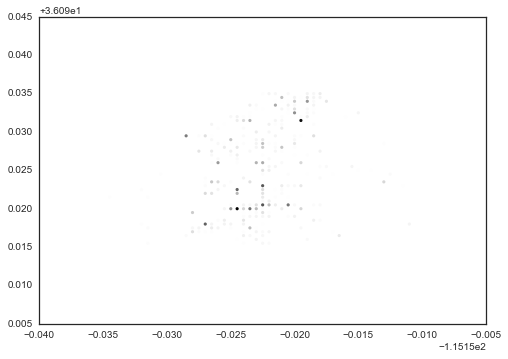

In [1138]:
# This function takes a vector of M intensities and plots it according to the coordinates in `X`.
# The values of the intensities are normalized to [0,1] and darker means higher values
def plot_checkins(checkins):
    colors = checkins / np.double(np.max(checkins))
    plt.scatter(X[:,0], X[:,1], s=10, c=colors, cmap='gray_r', edgecolors='none')
    plt.show()
    
plot_checkins(checkins)

In [1215]:
#elliptical slice sampler (Murray, Adams, and MacKay JMLR 2010)
# Inputs:
# Y: observed data
# Sig: covariance matrix of the prior
# log_lik: the log likelihood function
# N_mcmc: number of desired samples
# burn_in: number of burn in iterations
# N: dimensionality of the input, this should be M+1 because alpha is part of Sigma

# returns an array of samples of size N_mcmc x N

    
def ess(Y, Sig,log_lik, N_mcmc, burn_in, N):
    print 'running elliptical slice sampling...'
    mcmc_samples = np.zeros((N_mcmc+burn_in, N))
    norm_samples = np.random.multivariate_normal(np.zeros(N), Sig, N_mcmc+burn_in)
    unif_samples = np.random.uniform(0,1,N_mcmc+burn_in)
    theta = np.random.uniform(0,2*np.pi,N_mcmc+burn_in)
    theta_min = theta-2*np.pi
    theta_max = theta+2*np.pi
    for i in range(1,N_mcmc+burn_in):
        if i%1000==0:
            print i
        f = mcmc_samples[i-1,:]
        llh_thresh = log_lik(f,Y) + np.log(unif_samples[i])
        f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i])
        while log_lik(f_star,Y) < llh_thresh:
            if theta[i] < 0:
                theta_min[i] = theta[i]
            else:
                theta_max[i] = theta[i]
            theta[i] = np.random.uniform(theta_min[i],theta_max[i],1)  
            f_star = f*np.cos(theta[i])+norm_samples[i,:]*np.sin(theta[i]) 		
        mcmc_samples[i,:] = f_star
    return mcmc_samples[(burn_in+1):(burn_in+N_mcmc),]

## Conjugate Model

To get the posterior:
    
\begin{align}
p(\lambda_i | Y_i) \propto p(Y_i | \lambda_i)p(\lambda_i)\\
\end{align}

We have that $p(Y_i | \lambda_i) \~ Pois(w^2 \lambda_i)$ and $p(\lambda_i) \~Gamma(\alpha,\beta)$, so:
\begin{align}
p(Y_i | \lambda_i) &= \frac{(w^2 \lambda_i)^{Y_i} exp(-w^2 \lambda_i)}{Y_i!}\\
p(\lambda_i) &= \frac{\beta^{\alpha} \lambda_i^{\alpha-1} exp(-\lambda_i \beta)}{(\alpha - 1)!}
\end{align}

Multiplying these together, we get:
$$p(\lambda_i | Y_i) \propto 
\frac{\beta^\alpha exp(-\lambda_i (w^2+\beta)) \lambda_i^{\alpha+Y_i-1}w^2}{(Y_i)!(\alpha-1)!}$$

This is proportional to a $Gamma(\alpha',\beta')$ distribution with $\alpha' = \alpha + Y_i$ and $\beta' = w^2 + \beta$.

The mean of $Gamma(\alpha',\beta')$ is $\frac{\alpha'}{\alpha'+\beta'}$, so our posterior means will be equal to 
$\frac{\alpha + Y_i}{\alpha+ Y_i + w^2 + \beta}$

In [1144]:
def posterior_means(a, b, y=checkins, wid=w):
    return (a + y)/(a + y + wid**2 + b)

alpha:  1 , beta: 1
Max: 0.999962506083
Min: 0.4999999375
Mean: 0.580130836991


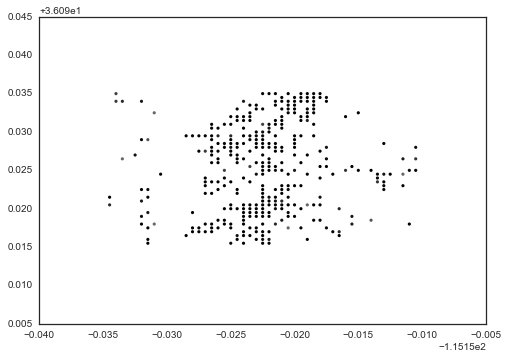

alpha:  1 , beta: 10
Max: 0.999625187397
Min: 0.090909088843
Mean: 0.22575031716


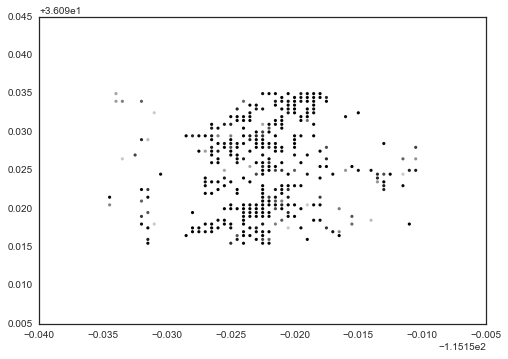

alpha:  1 , beta: 100
Max: 0.996264475149
Min: 0.0099009900745
Mean: 0.123481988443


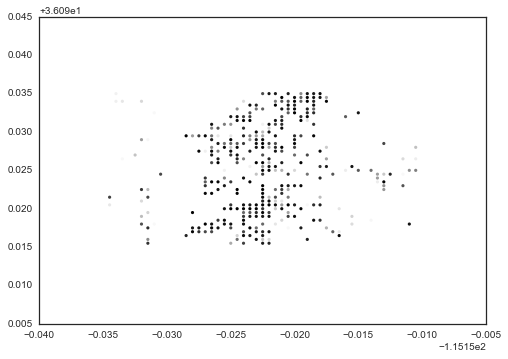

alpha:  10 , beta: 1
Max: 0.999962518731
Min: 0.90909088843
Mean: 0.922575014295


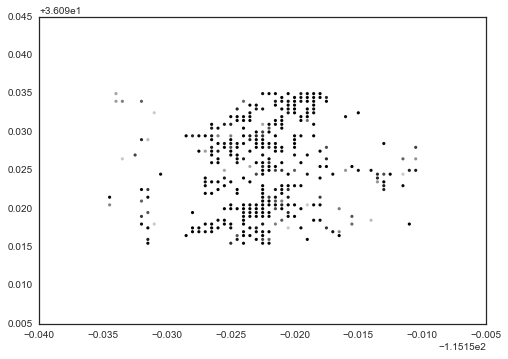

alpha:  10 , beta: 10
Max: 0.99962531379
Min: 0.49999999375
Mean: 0.570741317789


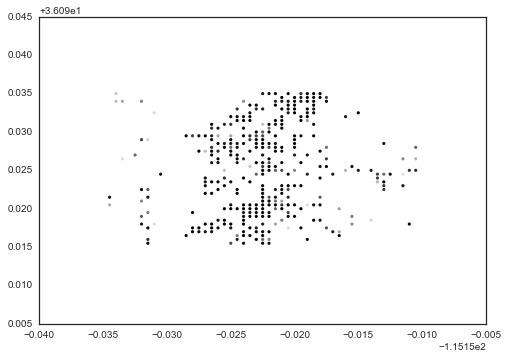

alpha:  10 , beta: 100
Max: 0.996265730601
Min: 0.0909090907025
Mean: 0.193600132451


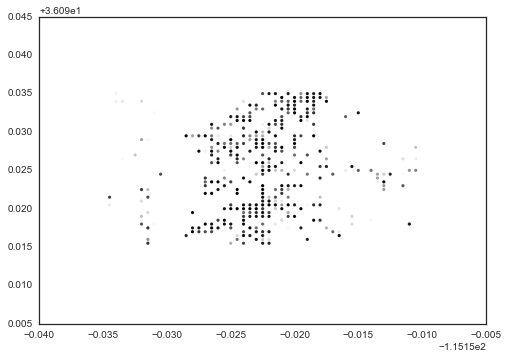

alpha:  100 , beta: 1
Max: 0.999962644742
Min: 0.99009900745
Mean: 0.991234817715


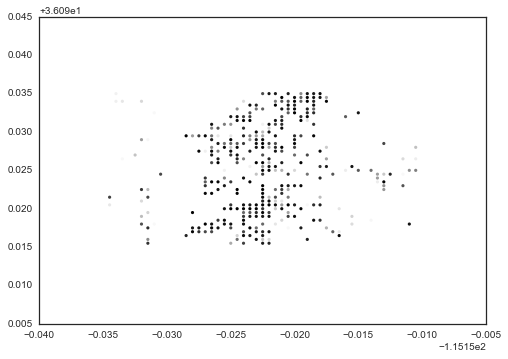

alpha:  100 , beta: 10
Max: 0.999626573052
Min: 0.909090907025
Mean: 0.919360011431


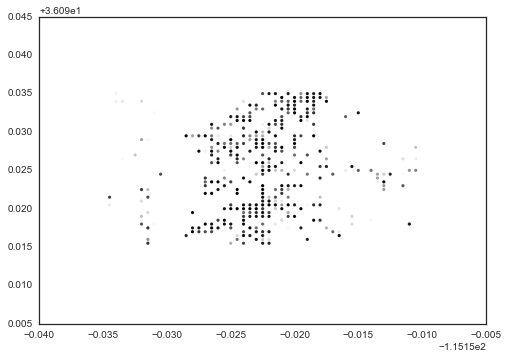

alpha:  100 , beta: 100
Max: 0.996278238853
Min: 0.499999999375
Mean: 0.549886492347


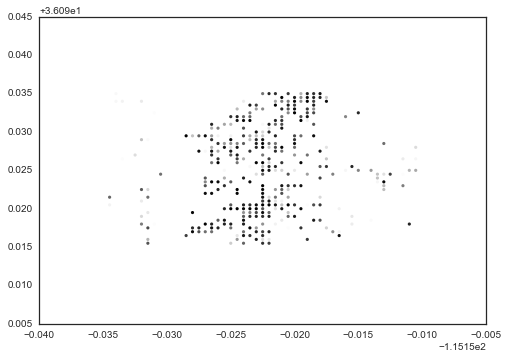

In [1149]:
for a in [1,10,100]:
    for b in [1,10,100]:
        means = posterior_means(a,b,checkins,w)
        print "alpha: ", a, ", beta:", b
        print "Max:",np.max(means)
        print "Min:",np.min(means)
        print "Mean:",np.mean(means)
        plot_checkins(means)

This model is very sensitive to the choice of prior values for alpha and beta.  It only effectively stratifies the probability of each point when beta is much larger than alpha.  Otherwise, the probability values tend to be pretty close to each other.  This requires us to have a strong prior belief, which it may be unreasonable.  



## Nonconjugate Model

In [1294]:
# First, make the covariance matrix
phi = .00001
Sigma = np.zeros((M+1,M+1))

### $\alpha$ controls the value of $\lambda$ for all of the data points.  This value describes the part of the probability of a checkin that is common for all of the points in the graph.  
### $\Sigma$ controls the distribution of $z$, which determines the impact of location on $\lambda_i$.  If $\Sigma$ is a diagonal matrix, there is no correlation between the points, and the $\lambda_i$ will be controlled only by $\alpha$.  If, on the other hand, $\Sigma$ describes a high amount of correlation between nearby points, we can expect the values of $\lambda_i$ to be similar for nearby points.  

### We can combine alpha and z into a single covariance matrix because both are normally distributed with a mean of zero.  Alpha is independent of the z values, so we simply put the variance of alpha (1) in the top-left corner of the matrix, and make the rest of the row and column that describe the correlation between alpha and the z values equal to zero.  

In [1295]:
# Set top left value equal to 1 as described above.  
Sigma[0,0]=1

# Fill it with the norms of differences in coordinates, negative and divided by phi
for i in range(M):
    for j in range(M):
        Sigma[i+1,j+1] = np.exp(-np.linalg.norm(X[i]-X[j])/phi)

In [1297]:
# Add a small amount to maintain numerical stability
Sigma1 = Sigma + 0.00001*np.eye(M+1)

In [1298]:
def log_likelihood(a_z, data):
    lambdas = np.exp(a_z[0]+a_z[1:])
    return np.sum(scipy.stats.poisson.logpmf(data, lambdas*w**2)) 

In [1299]:
%%time
samples = ess(checkins, Sigma1, log_likelihood, 10000,1000,2001)

running elliptical slice sampling...
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 1min, sys: 980 ms, total: 1min 1s
Wall time: 51.9 s


In [1300]:
means = np.mean(samples,axis=0)

### $\phi$ controls the strength of the effect of distance on the correlation between points on the covariance matrix.  For very small values, this effect is large, and the values of the points are more correlated.  For small values of phi, the points are less correlated, and the distribution of probability values across the map is less smoothed out.  

$\phi = 1$

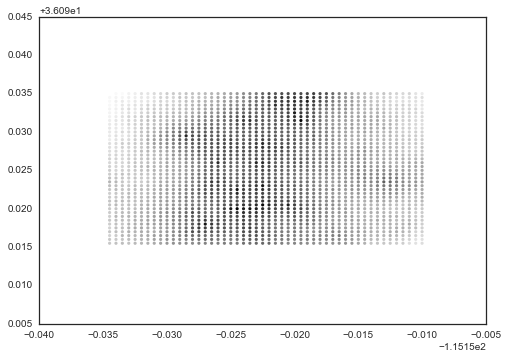

In [1293]:
plot_checkins(means[1:])

$\phi=0.01$

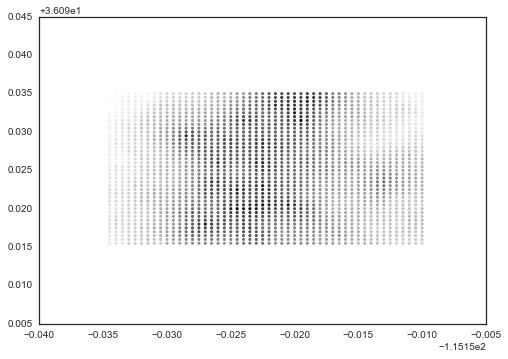

In [1286]:
plot_checkins(means[1:])

$\phi=0.00001$

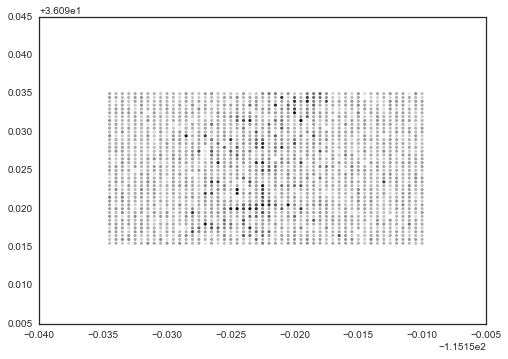

In [1301]:
plot_checkins(means[1:])

### The non-conjugate model is more realistic because it takes into account the impact of location on the probability of a checkin, which the conjugate model ignores.  

### Now with PyMC:

In [1304]:
Sigma2=Sigma1[1:,1:]

In [1331]:
alpha = pm.Normal("alpha",0,1)
zs = pm.MvNormal("zs", mu=np.zeros(2000), tau=Sigma2)

@pm.deterministic
def lambd(alpha=alpha,zs=zs):
    return np.exp(alpha+zs)

@pm.observed
def likelihood(value=checkins,alpha=alpha1,zs=zs):
    return np.sum([pm.poisson_like(value[i],lambd(alpha,zs[i])) for i in range(2000)])
        
M = pm.MCMC([checkins, alpha, zs, lambd, likelihood])
M.sample(1100,100,10)

TypeError: 'numpy.ndarray' object is not callable

In [1332]:
#### Surprise!  Unintelligible errors and no relevant documentation.

# Problem 2: Point Matching

In this problem you are given two point clouds `points1` and `points2`. Your task is to estimate an affine transformation which can map the points of `points1` onto the points of `points2`. Unfortunately you don't know which points from the two point sets correspond to each other.

We are modeling the correspondences in a correspondence matrix $M$, which is of size $n_1 \times n_2$ where $n_i$ is the number of points in point set $i$. $M_{ij}=1$ indicates that point $x_i$ from `points1` and $y_j$ from `points2` correspond to each other. Each point is only allowed to have one correspondence. So for all $i$ we have $\sum_l^{n_2} M_{il} = 1$ 

The likelihood for this problem is:

$$ \prod_i^{n_1} \prod_j^{n_2} \varphi_{0,\sigma}\left(||Ax_i - y_j||\right)^{M_{ij}} $$

where $\varphi_{0,\sigma}$ is a normal distribution with mean 0 and variance $\sigma^2$. We use $\sigma^2 = 0.01$ as a default for this problem. 

Estimate the affine transform $A$ that matches the two point sets using expectation maximization and simulated annealing and compare the results. What are the strength of each algorithm? Which one would you prefer in which scenario?

Here are some hints that should be useful:
* The M-step of the problem will be a weighted least squares solution. 
* To use linear algebra to solve the M step it is useful to extend the point matrices to contain all possible pairwise correspondence pairs. 
* The weights for the weighted least squares should be updated in your E-step

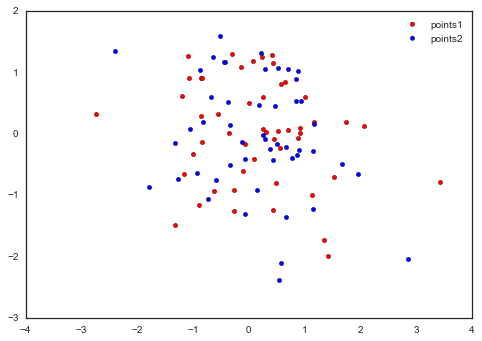

In [174]:
points1 = np.array([[-0.855,  0.905,  1.   ],[ 1.417, -1.999,  1.   ],[-0.896, -1.166,  1.   ],[-0.114, -0.604,  1.  ],
                    [ 2.055,  0.131,  1.   ],[ 0.694,  0.056,  1.   ],[-1.318, -1.495,  1.   ],[ 0.479, -0.799,  1.  ],
                    [-1.081,  0.91 ,  1.   ],[-0.273, -1.258,  1.   ],[ 1.733,  0.188,  1.   ],[ 0.65 ,  0.848,  1.  ],
                    [-0.007,  0.507,  1.   ],[-0.262, -0.922,  1.   ],[-0.14 ,  1.078,  1.   ],[ 0.239,  1.246,  1.  ],
                    [ 0.528,  0.036,  1.   ],[ 0.31 ,  0.025,  1.   ],[-2.734,  0.325,  1.   ],[ 1.014,  0.597,  1.  ],
                    [-0.839, -0.137,  1.   ],[ 0.924,  0.012,  1.   ],[ 0.09 , -0.407,  1.   ],[ 0.433, -1.236,  1.  ],
                    [ 1.345, -1.731,  1.   ],[-0.362,  0.012,  1.   ],[ 0.416,  1.279,  1.   ],[ 1.165,  0.185,  1.  ],
                    [ 0.446, -0.088,  1.   ],[-1.006, -0.335,  1.   ],[ 0.072,  1.188,  1.   ],[ 0.25 ,  0.076,  1.  ],
                    [ 1.525, -0.699,  1.   ],[ 0.574,  0.805,  1.   ],[-1.171, -0.655,  1.   ],[ 0.873, -0.067,  1.  ],
                    [-0.306,  1.291,  1.   ],[-0.07 , -0.174,  1.   ],[-1.088,  1.27 ,  1.   ],[-0.864,  0.295,  1.  ],
                    [-0.845,  0.914,  1.   ],[ 1.136, -1.001,  1.   ],[-0.55 ,  0.328,  1.   ],[-1.201,  0.621,  1.  ],
                    [-0.617, -0.941,  1.   ],[ 0.438,  1.147,  1.   ],[ 0.252,  0.593,  1.   ],[ 3.42 , -0.792,  1.  ],
                    [ 0.923,  0.096,  1.   ],[ 0.563, -0.235,  1.   ]])

points2 = np.array([[-0.131, -0.134,  1.   ],[-2.402,  1.347,  1.   ],[ 0.137, -0.921,  1.   ],[ 0.581, -2.113,  1.  ],
                    [ 0.283,  1.049,  1.   ],[-0.734, -1.058,  1.   ],[ 0.26 , -0.025,  1.   ],[ 0.296, -0.095,  1.  ],
                    [ 0.211,  1.31 ,  1.   ],[ 0.874,  1.023,  1.   ],[-0.336, -0.515,  1.   ],[ 0.859, -0.343,  1.  ],
                    [-0.073, -1.308,  1.   ],[-1.058,  0.075,  1.   ],[ 0.544, -2.389,  1.   ],[-0.827,  0.195,  1.  ],
                    [ 0.666, -1.36 ,  1.   ],[ 0.698,  1.059,  1.   ],[-1.274, -0.734,  1.   ],[-0.52 ,  1.589,  1.  ],
                    [ 1.141, -1.229,  1.   ],[ 0.89 , -0.265,  1.   ],[ 0.521,  1.07 ,  1.   ],[-0.651,  1.254,  1.  ],
                    [-0.686,  0.603,  1.   ],[ 0.502, -0.169,  1.   ],[ 0.925,  0.535,  1.   ],[-0.93 , -0.634,  1.  ],
                    [-0.33 ,  0.149,  1.   ],[-0.431,  1.168,  1.   ],[ 0.43 , -0.433,  1.   ],[ 1.949, -0.665,  1.  ],
                    [-0.872,  1.033,  1.   ],[ 0.378, -0.252,  1.   ],[-1.79 , -0.877,  1.   ],[ 0.781, -0.396,  1.  ],
                    [ 1.147, -0.275,  1.   ],[-0.073, -0.41 ,  1.   ],[ 1.673, -0.489,  1.   ],[-1.332, -0.157,  1.  ],
                    [-0.444,  1.163,  1.   ],[ 0.459,  0.452,  1.   ],[ 0.843,  0.892,  1.   ],[ 0.662, -0.214,  1.  ],
                    [ 0.838,  0.524,  1.   ],[ 0.188,  0.471,  1.   ],[ 1.166,  0.164,  1.   ],[-0.595, -0.751,  1.  ],
                    [-0.382,  0.514,  1.   ],[ 2.857, -2.04 ,  1.   ]])

plt.scatter(points1[:,0], points1[:,1], c='r', label='points1')
plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.legend()
plt.show()

In [1117]:
def error(x,y,m):
    """
    Inputs:
    -------
    x: Matrix of points
    y: Matrix of points, same as x but different order
    m: Correspondence matrix that maps y to x
    
    Outputs:
    --------
    err: value of sum of errors for the points
    """
    
    ordered_y = np.array([y[np.argmax(m[i,:]),:] for i in range(len(x))])
    
    # Get affine transform matrix that corresponds to these two sets of points
    affine = np.dot(np.linalg.pinv(x),ordered_y)

    err = 0
    
    # Using the sum of the errors as the energy function
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            if m[i,j]==1: # if these two points correspond in M
                err += np.linalg.norm(np.dot(x[i],affine)-y[j])
    
    return err, affine

In [1119]:
def swap_rows(matrix):
    m = matrix.copy()
    size = m.shape[0]
    row_idx_1 = np.random.randint(size)
    row_idx_2 = np.random.randint(size)
    row_to_swap = matrix[row_idx_1,:]
    m[row_idx_1] = matrix[row_idx_2]
    m[row_idx_2] = row_to_swap

    return m
    

In [1120]:
def simulated_annealing(x=points1, y=points2, mat=swap_rows(np.eye(50)), init_temp=1, min_temp=0.01, \
                                                        cool_by=0.99, reanneal=100, num_iter=1000):
    """
    Inputs:
    -------
    x: matrix of points
    y: matrix of points, same as x but swapped order
    mat: initial correspondence matrix
    init_temp: float that controls the initial temperature of the algorithm
    min_temp: float that acts as a floor for the decreasing temperature.  When this is hit, we heat back
        up to init_temp.  
    cool_by: float that controls the speed that the cooling occurs
    reanneal: integer that controls how many iterations pass between cooling steps
    num_iter: integer that controls the total number of iterations that the algorithm runs
    
    Returns:
    --------
    states: a history of the current energy state at each iteration
    best_m: the best correspondence matrix found
    """
    
    # A running account of the best bag found.  This is updated as better bags are found.
    best_energy,best_affine = error(x,y,mat)
    best_m = np.copy(mat)
    
    # We work with a copy of the original correspondence matrix.
    m=np.copy(mat)
    
    # Initial value for old_E is the initial total value of the starting point.
    old_E = best_energy
    
    temperature = init_temp
    
    # A history of the current state of the algorithm
    states = np.zeros(num_iter)
    

    for i in range(num_iter):
        # Switch the bag up a little bit
        proposed_m = swap_rows(m)

        # Examine energy state of the new bag
        new_E,new_affine = error(x,y,proposed_m)
        delta_E = new_E - old_E
        
        # We always accept an improvement
        if new_E < old_E:
            m = np.copy(proposed_m)
            states[i] = new_E
            old_E = new_E

            # Update our running best bag found
            if new_E < best_energy:
                best_energy = new_E
                best_m = m
                best_affine = new_affine
        # We sometimes accept a decline because this can get us out of a local minimum
        elif np.random.rand() < np.exp(-delta_E/temperature):
            m = np.copy(proposed_m)
            states[i] = new_E
            old_E = new_E

        # And sometimes we just stay where we are until something better comes along
        else: 
            states[i] = old_E
            
        # Cool down slowly at the defined interval
        if i % reanneal == 0:
            temperature = temperature * cool_by
            
            # Reheat when the temperature gets too cold
            if temperature < min_temp:
                temperature = init_temp

    return states, best_m, best_affine

In [1121]:
%%time
st1, best_m, best_affine = simulated_annealing(mat=best_m, init_temp=1, min_temp = 0.00000000001,reanneal=2,num_iter=10000)

CPU times: user 13 s, sys: 32.9 ms, total: 13 s
Wall time: 13.1 s


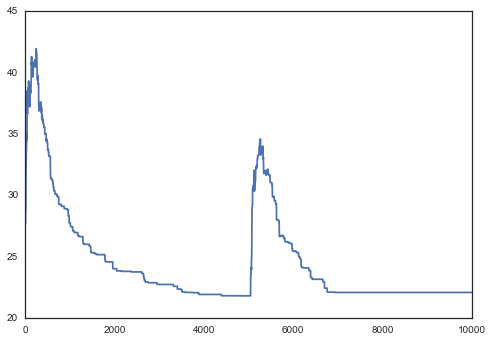

In [1122]:
plt.plot(st1)

In [1123]:
best_affine

array([[ -4.31418912e-01,  -5.31409157e-01,   5.46437895e-17],
       [  7.91291802e-01,  -8.80840842e-01,  -1.82145965e-16],
       [  1.97778844e-01,   2.99651190e-02,   1.00000000e+00]])

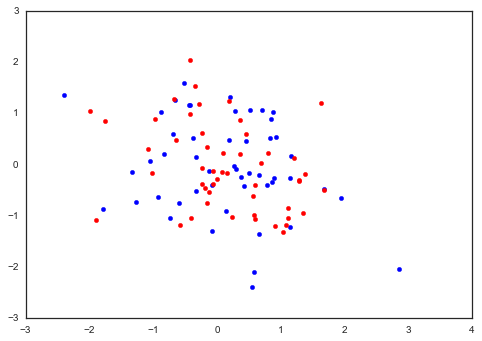

In [1124]:
ordered_y = np.array([points2[np.argmax(best_m[i,:]),:] for i in range(50)])
# affine = np.dot(np.linalg.pinv(points1),ordered_y)
affined_x = np.dot(points1, best_affine)

plt.scatter(ordered_y[:,0],ordered_y[:,1],color='b')
plt.scatter(affined_x[:,0],affined_x[:,1],color='r')



### I wasn't able to find the correct correspondence matrix using simulated annealing

### Expectation Maximization

In [1412]:
length = len(points1)

# Make the n^2 by 3 matrixes to use in EM
points1_prime = np.zeros((length**2,3))
for i in range(length):
    points1_prime[i*length:(i+1)*length]=points1[i]
    
points2_prime = np.zeros((length**2,3))
for i in range(length):
    points2_prime[i*length:(i+1)*length]=points2
    

In [1460]:
# Copy of last iteration's Affine matrix.  Used to check for convergence.  
# Initialized to nonsense value.  
old_A = 10*np.eye(3)

# Affine Matrix
A = np.eye(3)

# Iteration counter
i=0

while True:
    
    ### Expectation step
    
    # Calculate errors on prime matrices given Affine transform
    norms = np.linalg.norm(points1_prime.dot(A) - points2_prime, axis=1)
    
    # Get probabilities of these norms
    probs = scipy.stats.norm.pdf(norms,0,scale=0.1)
    
    # G matrix contains all of these probabilities
    G = probs.reshape(50,50)
    
    # Normalize rows of G
    for j in range(G.shape[0]):
        G[j]=G[j]/sum(G[j])
    
    # Reform G_prime
    G_prime = np.zeros((2500,2500))
    np.fill_diagonal(G_prime,G)
    
    # Convergence test.  When Affine matrix stops getting better, break.  
    if np.linalg.norm(old_A - A)<0.000001:
        print "Converged at", i, "iterations"
        print A
        break
    
    ### Maximization Step
    old_A = A
    A,_,_,_ = np.linalg.lstsq((points1_prime.T).dot(G_prime).dot(points1_prime),\
                        (points1_prime.T).dot(G_prime).dot(points2_prime))
    
    i+=1

Converged at 17 iterations
[[  9.22708242e-01  -3.82285348e-01  -6.39186807e-17]
 [  3.82508308e-01   9.22794261e-01  -2.96467802e-16]
 [  5.54383526e-04  -4.43032071e-05   1.00000000e+00]]


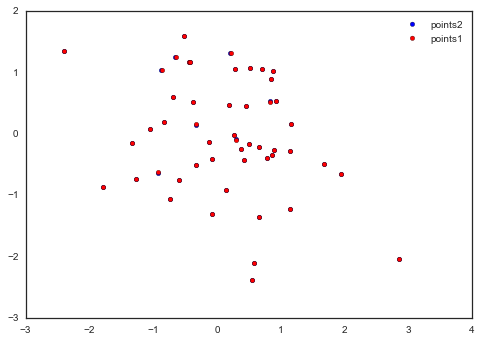

In [1461]:
### Show that it works:
points3 = points1.dot(A)

plt.scatter(points2[:,0], points2[:,1], c='b', label='points2')
plt.scatter(points3[:,0], points3[:,1], c='r',label='points1')

plt.legend()
plt.show()

The strength of Simulated Annealing is that you can use it even when you can't generate a likelihood.  
The strength of EM is that it works like a charm!  
Both converge to local optima, so they don't guarantee the global optimum.  

# Problem 3 Time Series

Below you find 200 data points from a time series. Your task is to model this data using a simple autoregressive model:

$$
X_t=\alpha X_{t-1}+r_t
$$
where $r_t$ is normally distributed: $r_t \sim\mathcal{N}(0,\sigma^2)$

Here are your tasks:
* Implement a maximum likelihood estimation(MLE) method to estimate $\alpha$
* Use any MCMC algorithm of your choice to infere $\sigma^2$ and $\alpha$
* Forecast 3 time points ahead and provide posteriors for these three points

In [7]:
# Here is the data
y=np.array([0.00000000e+00,  -2.41884381e-01,  -2.19815584e-01, -5.92654275e-03,   3.89498469e-02,  -7.06374756e-01,
         6.09244734e-02,  -1.36663360e+00,  -1.63887006e+00, -1.31721354e+00,  -1.52424274e+00,  -1.23902096e+00,
        -6.63029664e-01,  -5.97693396e-01,   1.26359198e-01, 6.55116724e-01,   2.98253859e-01,   7.19461104e-03,
         4.04113046e-01,   7.29893878e-01,  -1.96731327e-03, 4.64230686e-01,  -6.79727540e-02,  -4.19137503e-01,
        -4.03256074e-01,  -8.70131096e-01,  -8.25921060e-01, 4.69417714e-01,  -1.00177377e-01,   6.34076840e-02,
        -1.05978178e-01,  -1.48916430e-01,  -5.43573786e-02, 4.61970441e-01,   8.18280558e-01,   2.87185308e-01,
         1.26715777e+00,   6.41828280e-01,   8.77364512e-01, 3.67214345e-01,   6.26413729e-01,   2.87102039e-02,
         4.28449069e-01,   7.31450267e-01,   6.19131504e-01, 6.33373751e-01,   3.17572088e-01,   3.51692600e-01,
        -2.48995087e-02,  -2.53030153e-01,  -2.15503832e-01,-6.20238803e-01,  -5.28176551e-01,  -5.99112522e-01,
         3.32834574e-01,   4.01426008e-01,  -6.37956657e-01,-4.52884655e-01,  -1.16203988e+00,  -8.82257305e-01,
        -6.19309194e-01,  -4.78009274e-01,  -2.32960888e-01, 3.80860392e-01,  -5.52337194e-01,   6.43589528e-01,
        -1.71939822e-01,  -2.22714248e-02,   1.69698173e-01, 2.26875861e-01,   6.27784254e-02,   9.59070565e-01,
        -2.00412521e-01,   1.62853318e-02,  -1.64492388e-02,-5.92514844e-01,  -1.43386816e-01,  -9.50829381e-01,
        -1.07109089e+00,  -5.47941202e-01,  -6.80501959e-01,-1.22073393e+00,  -5.09858830e-01,  -1.24176275e+00,
        -6.30383282e-01,  -8.67182207e-01,  -9.67761290e-01,-1.79674059e-01,   6.09919157e-01,   9.95635469e-02,
         2.28199545e-01,   4.21792446e-01,   1.69467875e-01,-2.59645693e-01,  -4.93207819e-01,  -5.01539736e-01,
        -6.05873935e-01,  -6.11037064e-01,   1.01647103e-01,-1.44991643e-01,  -4.33238432e-02,  -6.41062073e-02,
        -2.85514261e-01,  -3.95586179e-01,  -3.57194799e-01,-2.20170569e-01,  -3.39918202e-01,   1.70035788e-01,
         7.41558107e-01,   8.33120964e-01,   3.73995334e-01, 4.83141624e-01,  -1.28861162e-01,  -4.22192149e-01,
         5.78378631e-01,   1.43550174e-01,  -1.31226657e-01,-5.30885377e-01,  -8.76270272e-01,  -4.34154230e-01,
        -5.02379201e-01,  -5.14585915e-01,  -4.64397849e-01, 1.65475660e-01,   1.07774616e-01,  -9.65587168e-01,
        -8.60566293e-01,  -2.36405434e-01,  -4.12606502e-01,-5.58566210e-01,   1.20028400e+00,   9.96896069e-01,
         4.41653164e-01,   1.59249052e-01,  -1.74168536e-01, 5.63049814e-01,   7.39366310e-01,   6.05361272e-01,
         2.79509214e-01,  -6.26883609e-01,  -4.44982987e-01,-8.69359696e-01,  -9.27422224e-01,  -6.98179880e-01,
        -1.35445853e+00,  -1.12329955e+00,  -4.94572306e-01,-3.40507834e-01,  -8.37907253e-01,  -9.97003760e-01,
        -7.69088724e-01,  -4.77378429e-01,   4.52315984e-02, 8.76114754e-02,  -9.24336169e-02,   4.42178858e-01,
         6.32190755e-01,   8.18383124e-01,   2.95975304e-01,-2.38797237e-02,   1.16395924e-01,   5.62311884e-02,
        -3.15966789e-01,  -3.16808474e-01,  -1.16651970e+00,-1.01729199e+00,  -7.75285712e-01,  -4.17618624e-01,
        -7.65156825e-01,  -5.10469718e-01,  -3.25334859e-01, 1.06358791e-01,   4.03467712e-01,   5.62837155e-01,
         5.87793605e-01,   4.38191557e-01,  -4.17879322e-01,-3.19715350e-01,   3.41624528e-01,   4.93054502e-01,
         3.69746949e-01,   9.62398763e-02,  -2.81485049e-01,-3.37776564e-01,  -1.30858217e-03,   9.83538405e-01,
         6.94986165e-01,   2.41137851e-01,   2.79478944e-01, 5.13500357e-01,   4.17786188e-01,   7.46707509e-01,
         1.25038407e+00,   8.17699739e-01,   8.78811468e-02,-1.20413802e-01,  -1.83227208e-01,   8.06195706e-02,
         4.16043086e-01,   6.45585187e-02])


### MLE solution
Each $X_t$ depends only on the previous observation $X_{t-1}$, and the errors are normally distributed with mean 0 and variance $\sigma^2$, so 

$X_{t} \sim\mathcal{N}(\alpha  X_{t-1}, \sigma^2)$

So the likelihood is:

\begin{align}
p(X|\alpha,\sigma) &= \prod_{t=1}^T \frac{1}{\sigma \sqrt{2 \pi}} exp \Big( -\frac{(X_t - \alpha X_{t-1})^2}{2 \sigma^2} \Big)\\
&= \frac{(2 \pi)^{-\frac{T}{2}}}{\sigma^T} exp \Big( -\frac{\sum_{t=1}^T (X_t - \alpha X_{t-1})^2}{2 \sigma^2} \Big)
\end{align}

Then the log-likelihood is:

$$L(\theta) = -\frac{T}{2}log(2\pi) - T \space log(\sigma) - \Big( \frac{\sum_{t=1}^T (X_t - \alpha X_{t-1})^2}{2 \sigma^2} \Big)$$

To find the MLE estimate of \alpha, we differentiate the log-likelihood with respect to \alpha and set it equal to zero:

\begin{align}
\frac{\delta L}{\delta \alpha} = 0 &= -\frac{1}{2 \sigma^2} \sum_{t=1}^T 2(X_t - \alpha X_{t-1})(-X_{t-1})\\
0 &= \sum_{t=1}^T \alpha(X_{t-1})^2 - \sum_{t=1}^T X_{t}X_{t-1}\\
\sum_{t=1}^T X_{t}X_{t-1} &= \sum_{t=1}^T \alpha(X_{t-1})^2\\
\sum_{t=1}^T X_{t}X_{t-1} &= \alpha \sum_{t=1}^T (X_{t-1})^2\\
\alpha &= \frac{\sum_{t=1}^T X_{t}X_{t-1}}{\sum_{t=1}^T (X_{t-1})^2}
\end{align}

Note that as I have written this, $X$ is zero-indexed.  So we can use our data to get the MLE estimate for $\alpha$ using the above formula:

In [201]:
print "MLE estimate for alpha:"
print np.sum([y[i]*y[i-1] for i in range(1,len(y))])/np.sum([y[i-1]**2 for i in range(1,len(y))])

MLE estimate for alpha:
0.681646977553


### Now with PyMC:

In [264]:
alpha1 = pm.Uniform("alpha1",-.99,0.99)
sigma1 = pm.Uniform("sigma1",0,1)
T = len(y)

@pm.observed
def likelihood(value=y,alpha=alpha1, sigma=sigma1):
    return -0.5*T*np.log(2*np.pi) - T*np.log(sigma) - \
            (1./(2.*sigma**2))*np.sum([(value[t] - alpha*value[t-1])**2 for t in range(1,T)])
    
M = pm.MCMC([y, alpha1, sigma1, likelihood])
M.sample(110000,1000,10)

 [-----------------100%-----------------] 110000 of 110000 complete in 72.0 sec

Plotting alpha1


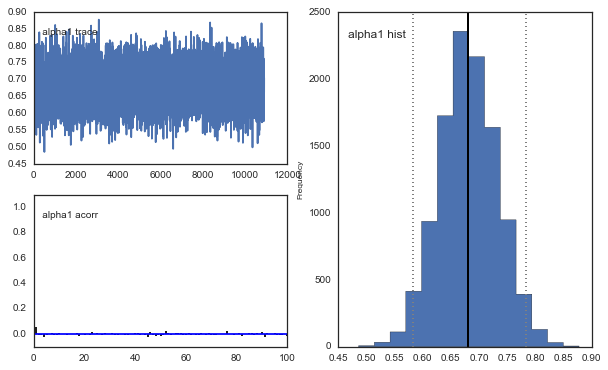

In [265]:
pm.Matplot.plot(alpha1)

Plotting sigma1


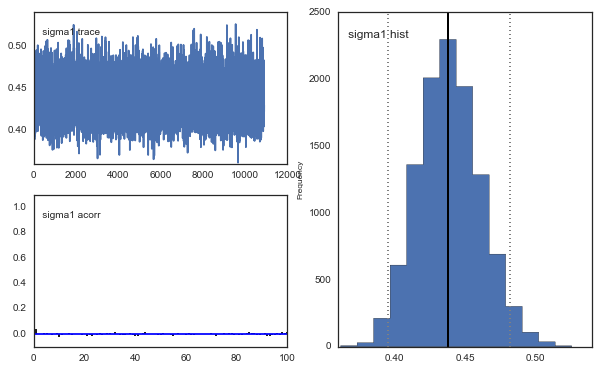

In [266]:
pm.Matplot.plot(sigma1)

In [268]:
# likelihood(y, alpha1.summary().mean())
print "Alpha:", alpha1.stats()['mean'],", Alpha error:", alpha1.stats()['standard deviation']
print "Sigma:", sigma1.stats()['mean'],", Sigma error:", sigma1.stats()['standard deviation']

Alpha: 0.681138104206 , Alpha error: 0.0514793001965
Sigma: 0.438988695257 , Sigma error: 0.0221980378547


In [269]:
alpha = alpha1.stats()['mean']
sigma = sigma1.stats()['mean']

### I will present my forecasts as posterior distributions.
### To do this, I will sample alpha and sigma values from the traces of their samplings.  

In [270]:
num_samples = 1000000
# I forecasted 20 points ahead because I was curious to look further, but I present the first 3 as my results
num_forecasts = 20

# Sample alphas and sigmas
sigmas = np.random.choice(sigma1.trace(), num_samples)
alphas = np.random.choice(alpha1.trace(), num_samples)
sample_forecasts = np.zeros((num_samples, num_forecasts))


for i in range(num_samples):
    alf = alphas[i]
    sig = sigmas[i]
    # Use the samples sigma to make 
    errors = np.random.normal(loc=0, scale=sig, size=num_forecasts)
    sample_forecasts[i,0] = y[-1]*alf + errors[0]
    for j in range(1,num_forecasts):
        sample_forecasts[i,j] = sample_forecasts[i,j-1]*alf + errors[j]

In [342]:
def formatt(stat):
    return "{0:.3f}".format(stat)

Mean of forecast 0 : 0.044 +/- 0.440
Mean of forecast 1 : 0.030 +/- 0.532
Mean of forecast 2 : 0.021 +/- 0.570


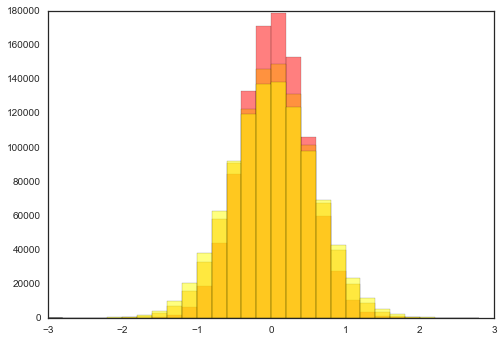

In [343]:
cmap = ["red","orange","yellow","green","blue","green","purple","black"]
mean = np.zeros(num_forecasts)
std = np.zeros(num_forecasts)
for i in range(3):
    plt.hist(sample_forecasts[:,i], bins=np.arange(-3,3,.2), color = cmap[i%len(cmap)], alpha=0.5);
    mean[i] = np.mean(sample_forecasts[:,i])
    std[i] = np.std(sample_forecasts[:,i])
    print "Mean of forecast", i, ":", formatt(mean[i]), "+/-", formatt(std[i])

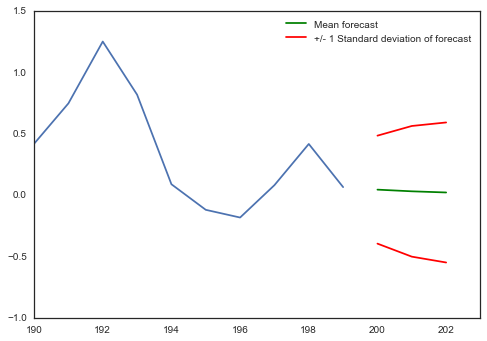

In [424]:
plt.plot(range(190,200),y[190:200])
plt.plot(200+np.array(range(3)),mean[0:3], color='green',label="Mean forecast")
plt.plot(200+np.array(range(3)),mean[0:3]+std[0:3], color='red', label = "+/- 1 Standard deviation of forecast")
plt.plot(200+np.array(range(3)),mean[0:3]-std[0:3], color='red')
plt.legend(loc='best')
plt.xlim((190,203));

### The mean of the forecast values approaches zero because the expected value of the error terms is zero and $\alpha < 1$.  The uncertainty in the forecasts comes from the uncertainty in the error term and the uncertainty of the hyperparameters $\alpha$ and $\sigma$.  The uncertainty of the forecasts grows with each forecast because each forecast is based on the previous error forecast, which was uncertain.  This causes the histograms to widen with each successive forecast.  

Interestingly, looking beyond the first 3 forecasts, the distribution of the forecasts converges and does not continue to widen.  I believe that this is because as points get further from 0, the impact of the fractional $\alpha$ to pull them back towards 0 increases, and the time series tends not to deviate far from 0.  

Mean of forecast 0 : 0.044 +/- 0.440
Mean of forecast 1 : 0.030 +/- 0.532
Mean of forecast 2 : 0.021 +/- 0.570
Mean of forecast 3 : 0.014 +/- 0.589
Mean of forecast 4 : 0.010 +/- 0.598
Mean of forecast 5 : 0.007 +/- 0.604
Mean of forecast 6 : 0.005 +/- 0.605
Mean of forecast 7 : 0.003 +/- 0.607
Mean of forecast 8 : 0.002 +/- 0.607
Mean of forecast 9 : 0.001 +/- 0.607
Mean of forecast 10 : 0.001 +/- 0.607
Mean of forecast 11 : 0.001 +/- 0.608
Mean of forecast 12 : 0.001 +/- 0.608
Mean of forecast 13 : 0.001 +/- 0.608
Mean of forecast 14 : 0.001 +/- 0.608
Mean of forecast 15 : 0.001 +/- 0.608
Mean of forecast 16 : 0.001 +/- 0.608
Mean of forecast 17 : -0.000 +/- 0.607
Mean of forecast 18 : -0.000 +/- 0.607
Mean of forecast 19 : -0.000 +/- 0.607


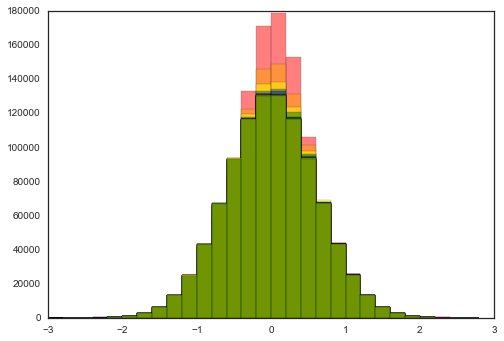

In [344]:
cmap = ["red","orange","yellow","green","blue","green","purple","black"]
mean = np.zeros(num_forecasts)
std = np.zeros(num_forecasts)
for i in range(num_forecasts):
    plt.hist(sample_forecasts[:,i], bins=np.arange(-3,3,.2), color = cmap[i%len(cmap)], alpha=0.5);
    mean[i] = np.mean(sample_forecasts[:,i])
    std[i] = np.std(sample_forecasts[:,i])
    print "Mean of forecast", i, ":", formatt(mean[i]), "+/-", formatt(std[i])

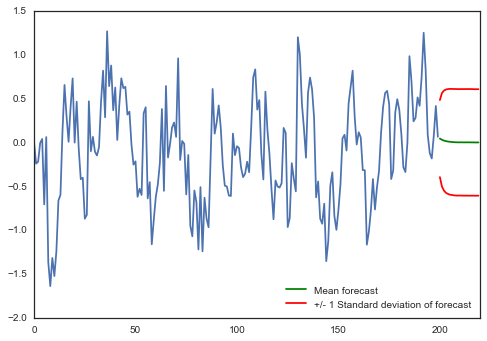

In [286]:
plt.plot(range(200),y)
plt.plot(200+np.array(range(20)),mean, color='green',label="Mean forecast")
plt.plot(200+np.array(range(20)),mean+std, color='red', label = "+/- 1 Standard deviation of forecast")
plt.plot(200+np.array(range(20)),mean-std, color='red')
plt.legend(loc='best')
plt.xlim((0,220));

# Extra Problem 4: Final Project Proposal 

Think about your final project proposal. Your final project is your chance to show off what you learned in AM207! You have seen a lot of different models and examples in lecture and in the homework assignments. In your final project you are free to apply all the techniques you learned to an area of your choice. Be careful not to choose data that you still need to label yourself or that will take you ages to clean. The main focus should be on finding a good model and comparing different techniques for sampling, optimization, etc. 

Please note that there will be a google spreadsheet where you can submit your final project proposal abstract. No need to write it into this notebook. 

The abstract should be short, but contain a short description of your final project idea, which methods you are planning on using, and where your data will come from. 